# Задание 7.

Реализовать решение ОДУ сеточным методом.

* Начинать вычисления с грубой сетки (примерно 10 интервалов); измельчать сетку и уточнять по Ричардсону. В идеале — до момента выхода на ошибки округления.
* Отследить, какая точность (например, от 1e−2 до 1e−6) достигнута при каком шаге сетки.
* Выводить полученное приближение. Можно на картинке.

**Отчёт:** https://docs.google.com/document/d/10R0FYQ77_k4GssDCVVLXEujL4J_dZeoRjzeyiBVZujw/edit?usp=sharing

# Imports

In [1]:
from functools import reduce
from typing import Callable, Tuple, List
import numpy as np
import numpy as np
from math import exp, pi, sin, cos
import matplotlib.pyplot as plt

# Solution

In [2]:
def initialize_grid(a: float, b: float, n: int) -> Tuple[float, List[float]]:
    h = (b - a) / n
    X = [a + h * i / 2 for i in range(2 * n + 1)]
    return h, X

def compute_intermediate_values(X: List[float], p: Callable, q: Callable, r: Callable, f: Callable):
    return zip(*[(p(x), q(x), r(x), f(x)) for x in X])

def compute_coefficients_fst(p_i, q_i, r_i, f_i, h, n):
    return zip(*[(-(p_i[i] / h + q_i[i] / 2) / h, 2 * p_i[i] / h ** 2 + r_i[i],
                  (-p_i[i] / h + q_i[i] / 2) / h, f_i[i]) for i in range(2, 2 * n, 2)])

def compute_coefficients_snd(p_i, q_i, r_i, f_i, h, n):
    return zip(*[(-(p_i[i - 1] / h + q_i[i] / 2) / h, (p_i[i + 1] + p_i[i - 1]) / h ** 2 + r_i[i],
                  (-p_i[i + 1] / h + q_i[i] / 2) / h, f_i[i]) for i in range(2, 2 * n, 2)])

def assemble_system(A, B, C, G, alpha1, alpha2, alpha, beta1, beta2, beta, h, n):
    A, B, C, G = [0.0] + list(A) + [-beta2 / h], [alpha1 + alpha2 / h] + list(B) + [beta1 + beta2 / h], \
                 [-alpha2 / h] + list(C) + [0.0], [alpha] + list(G) + [beta]

    M = np.array([[A[row] if row == column + 1 else B[row] if row == column else C[row] if row == column - 1 else 0
                   for column in range(n + 1)] for row in range(n + 1)])
    v = np.array(G)
    return M, v

def create_interpolating_function(Y, X, n):
    return lambda x: reduce(lambda y, i: Y[i // 2 + int(x - X[i] < X[i + 2] - x)] if X[i] < x <= X[i + 2] else y,
                            range(0, 2 * n, 2), Y[0])


def solve_using_grid_method(p: Callable, q: Callable, r: Callable, f: Callable, a: float, b: float, n: int,
                            alpha1: float, alpha2: float, alpha: float, beta1: float, beta2: float, beta: float,
                            fst=True) -> Callable:
    """
    p, q, f -- smooth functions, p(x) >= p0 > 0, r(x) >= 0, for a <= x <= b (WITHOUT CHECKING)
    
    For the differential equation:
    - If fst is True:
      -p(x) * y'' + q(x) * y' + r(x) * y = f(x)
    - Otherwise:
      -(p(x) * y')' + q(x) * y' + r(x) * y = f(x)
    In the interval a < x < b
    
    Boundary conditions:
    - At x = a: alpha1 * y(a) - alpha2 * y'(a) = alpha, |alpha1| + |alpha2| != 0, alpha1 * alpha2 >= 0
    - At x = b: beta1 * y(b) - beta2 * y'(b) = beta, |beta1| + |beta2| != 0, beta1 * beta2 >= 0
    """
    h, X = initialize_grid(a, b, n)
    p_i, q_i, r_i, f_i = compute_intermediate_values(X, p, q, r, f)

    if fst:
        A, B, C, G = compute_coefficients_fst(p_i, q_i, r_i, f_i, h, n)
    else:
        A, B, C, G = compute_coefficients_snd(p_i, q_i, r_i, f_i, h, n)

    M, v = assemble_system(A, B, C, G, alpha1, alpha2, alpha, beta1, beta2, beta, h, n)
    Y = np.linalg.solve(M, v)

    return create_interpolating_function(Y, X, n)

# Tests

In [3]:
n = 1000

p = lambda x: 1 / (x ** 3 + 5)
q = cos
r = exp
f = lambda x: sin(x) / (x ** 3 + 5) + cos(x) ** 2 + exp(x) * sin(x)
a, b = 0, pi / 2
alpha1, alpha2, alpha = 1, 0, 0
beta1, beta2, beta = 1, 1, 1
y = sin

h = (b - a) / n

actual = solve_using_grid_method(p, q, r, f, a, b, n, alpha1, alpha2, alpha, beta1, beta2, beta)
expected = sin

assert (all([abs(actual(x) - expected(x)) < h for x in [a + h * i for i in range(n)]]))

# Experiments

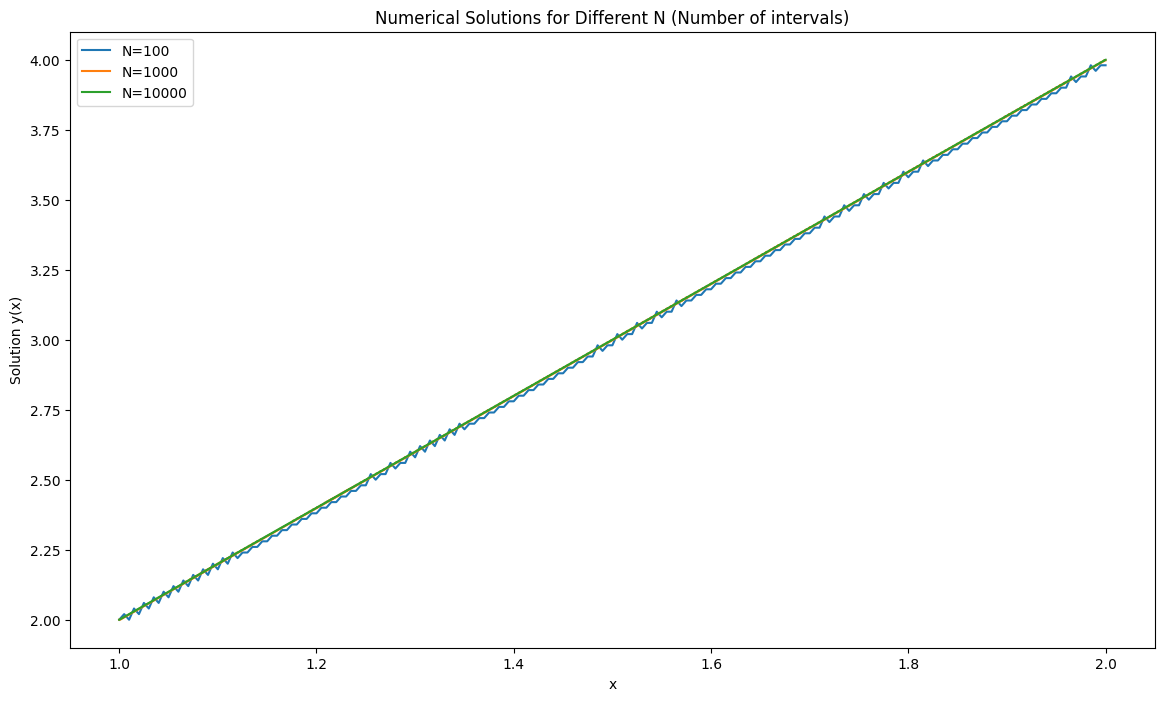

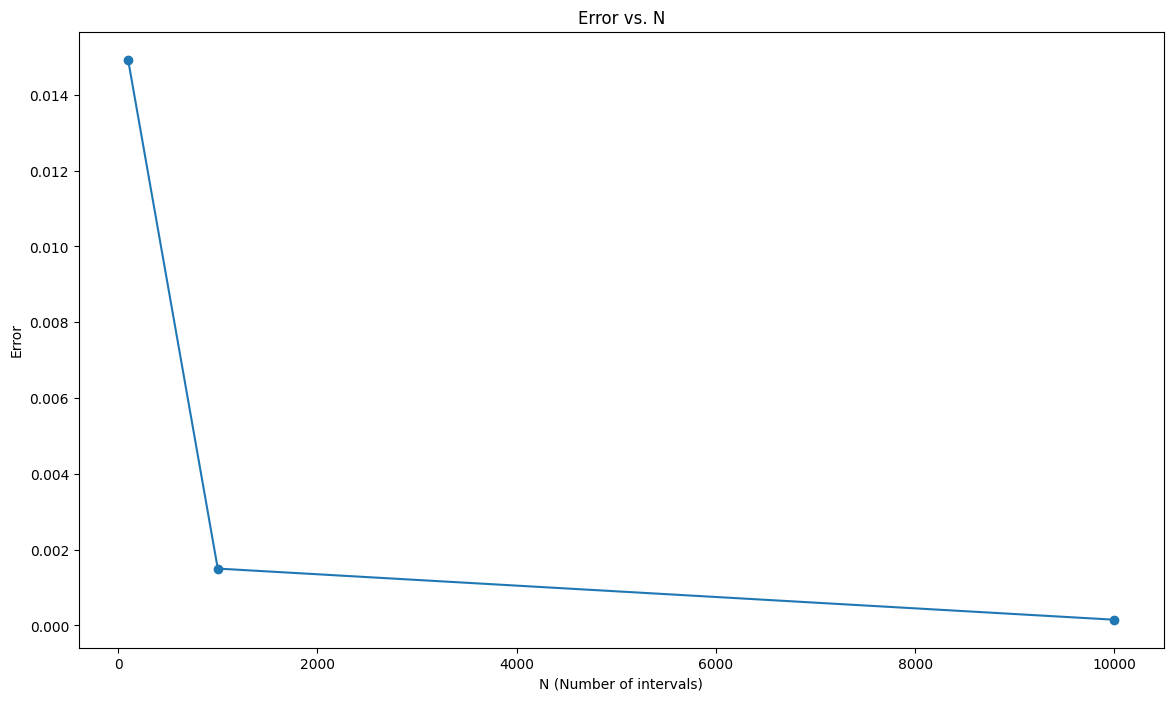

In [4]:
p = lambda _: 10
q = lambda x: x
r = lambda x: x
f = lambda x: 2 * x ** 2 + 2 * x
a, b = 1, 2
alpha1, alpha2, alpha = 1, 0, 2
beta1, beta2, beta = 1, 0, 4
y = lambda x: 2 * x
fst = False

N_values = [10 ** i for i in range(2, 5)]
errors = []

plt.figure(figsize=(14, 8))
for N in N_values:
    h, x_grid = initialize_grid(a, b, N)
    numerical_solution = solve_using_grid_method(p, q, r, f, a, b, N, alpha1, alpha2, alpha, beta1, beta2, beta, fst)
    plt.plot(x_grid, [numerical_solution(x) for x in x_grid], label=f'N={N}')

    analytical_solution = [y(x) for x in x_grid]
    error = np.mean(np.abs(np.array(analytical_solution) - np.array([numerical_solution(x) for x in x_grid])))
    errors.append(error)

plt.legend()
plt.title('Numerical Solutions for Different N (Number of intervals)')
plt.xlabel('x')
plt.ylabel('Solution y(x)')
plt.show()

plt.figure(figsize=(14, 8))
plt.plot(N_values, errors, marker='o')
plt.title('Error vs. N')
plt.xlabel('N (Number of intervals)')
plt.ylabel('Error')
plt.show()